# ECE-6524 / CS-6524 Deep Learning
# Assignment 5 (110 pts)

In this assignment, **you will implement the following:**
1. GAN / LSGAN loss functions and training code for MNIST dataset.
2. Train GAN / LSGAN on CelebA dataset with DCGAN architecture.

**<span style="color:red">Again, it may take hours to train on CelebA. So start early.</span>** (We don't want you to work during holidays)

## Submission guideline for the coding part (Jupyter Notebook)

1. Click the Save button at the top of the Jupyter Notebook
2. Please make sure to have entered your Virginia Tech PID below
3. Once you've completed everything (make sure output for all cells are visible), select File -> Download as -> PDF via LaTeX
4. Look at the PDF file and make sure all your solutions are displayed correctly there 
7. Zip this notebook (Please don't include the data). Name it as Assignment_3_Code_[YOUR PID NUMBER].zip
8. Name your PDF file as Assignment_4_NB_[YOUR PID NUMBER].pdf
9. **<span style="color:blue"> Submit your zipped file and the PDF SEPARATELY**</span>

Note: if facing issues with step 3 refer: https://pypi.org/project/notebook-as-pdf/

## Submission guideline for the coding part (Google Colab)

1. Click the Save button at the top of the Notebook
2. Please make sure to have entered your Virginia Tech PID below
3. Follow last two cells in this notebook for guidelines to download pdf file of this notebook
4. Look at the PDF file and make sure all your solutions are displayed correctly there 
5. Zip this notebook (Please don't include the data). Name it as Assignment_2_Code_[YOUR PID NUMBER].zip
6. Name your PDF file as Assignment_4_NB_[YOUR PID NUMBER].pdf
7. **<span style="color:blue"> Submit your zipped file and the PDF SEPARATELY**</span>

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

PID: 906355449

### Colab Setup: 
- Below are some basic steps for colab setup. 
- Make changes based on requirements.
- Comment out in case of ARC or your local device with powerful GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# modify "path_to_homework", path of folder in drive, where you uploaded your homework files
path_to_homework = "/content/drive/MyDrive/Assignment_5"
sys.path.append(path_to_homework)

# Section 1. Generative Adversarial Networks on MNIST Dataset [54 pts]

In this section, you will need to:
1. Implement two different types of loss functions (GAN / LSGAN) for generative adversarial networks. 
2. Build the Discriminator and Generator.
3. Implement training codes for your GAN models.
3. Train your model on MNIST dataset and visualize the generated images.

Now, let's get started!

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)

In [ ]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Section 1.1. Vanilla GAN loss functions

### Section 1.1.1 GAN Loss [10 pts]
We start from implementing the vanilla GAN loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). Specifically, you need to complete the `generator_loss` and `discriminator_loss` in the cell below.

Recalled from the class, the generator loss is written as:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these equations could be silghtly different from what we have seen before. This is because that in Pytorch, our optimize will be *minimizing* the loss functions. As a result, we negate the formulas to match pytorch's behavior.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss
import torch.nn.functional as F

In [ ]:
dtype = torch.FloatTensor

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
 
    #loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
        # get size of batch data
    #N = logits_real.size(0)
    #real_labels = torch.ones(size).type(dtype).to(device)

#     real_labels = torch.ones_like(logits_real).type(dtype).to(device)
#     #real_labels = torch.ones(logits_real).type(dtype).to(device)
 
#     # get size of batch data
#     #N = logits_fake.size(0)
#     #fake_labels = torch.ones(size).type(dtype).to(device)

#     #fake_labels = torch.zeros_like(logits_fake).type(dtype).to(device)
#     fake_labels = torch.ones_like(logits_fake).type(dtype).to(device)
#     #fake_labels = torch.zeros(logits_fake).type(dtype).to(device)

#     real_loss = bce_loss(logits_real, real_labels, reduction='mean'
#  )

#     fake_loss = bce_loss(logits_fake, fake_labels, reduction='mean'
# )

#     loss = real_loss + fake_loss
    
    loss = F.binary_cross_entropy_with_logits(logits_real, torch.ones(logits_real.size()).to(device),\
                                              reduction = 'mean') + \
    F.binary_cross_entropy_with_logits(1 - logits_fake, torch.ones(logits_fake.size()).to(device), \
                                      reduction='mean')

    ##########       END      ##########
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    #loss = None
 
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    # get size of batch data
    #N = logits_fake.size(0)
    #fake_labels = torch.ones(size).type(dtype).to(device)

#     fake_labels = torch.ones_like(logits_fake).type(dtype).to(device)
#     #fake_labels = torch.ones(logits_fake).type(dtype).to(device)


#     loss = bce_loss(logits_fake, fake_labels, reduction='mean')
    loss = F.binary_cross_entropy_with_logits(logits_fake, torch.ones(logits_fake.size()).to(device), \
                                              reduction = 'mean')

    ##########       END      ##########
    return loss

### Section 1.1.2 Build simple model [10 pts]

Build your simple model using below layers:

**Discriminator:**

- Flatten input (flatten the C x H x W into a single vector per image)
- linear (784, 256)
- Leaky ReLU ()
- Linear(256, 256)
- Leaky ReLU()
- Linear(256, 1)

**Generator:**
- Linear(noise_dim, 1024)
- ReLU()
- Linear(1024, 1024)
- ReLU()
- linear(1024, 784)
- Tanh()

In [ ]:
NOISE_DIM = 100


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

def generator(noise_dim=100):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model



### Section 1.1.3 Training code [10 pts]
You can't train a model without a proper training code. Implement the GAN training procedure here following the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) and the course slides in the cell below. Note that this code would be reused in the subsequent section, so make sure that it is correctly implemented.

In [ ]:
# sara
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
          ckpt_dir =path_to_homework+ '/ckpts/Vanilla_gan_MINST/', cont_train=False,
          batch_size=128, noise_size=NOISE_DIM, num_epochs=30, train_loader=None, device=device):
    """
    Train loop for GAN.

    The loop will consist of two steps: a discriminator step and a generator step.

    (1) In the discriminator step, you should zero gradients in the discriminator
    and sample noise to generate a fake data batch using the generator. Flatten real images 
    to 784 (28 * 28). Calculate the discriminator output for real and fake data, 
    and use the output to compute discriminator loss. Call backward() on the loss 
    output and take an optimizer step for the discriminator.

    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.

    You will need to reshape the fake image tensor outputted by the generator to
    be dimensions (batch_size x input_channels x img_size x img_size).

    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    if os.path.exists(os.path.join(ckpt_dir, 'checkpoint.pth')) and cont_train:
        ckpt = torch.load(os.path.join(ckpt_dir, 'checkpoint.pth'))
        start_epoch = ckpt['epoch'] + 1
        iter_count = ckpt['iter_count'] + 1
        G.load_state_dict(ckpt['G'])
        D.load_state_dict(ckpt['D'])
        print('Start from a checkpoint: {}, epoch:{}, iter:{}'.format(os.path.join(ckpt_dir, 'checkpoint.pth'), 
                                                 str(start_epoch), str(iter_count)))
    else:
        start_epoch = 0
        iter_count = 0
        
    for epoch in range(start_epoch, num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            x =x.to(device)
            _, input_channels, img_size, _ = x.shape

            real_images = preprocess_img(x)#.to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None  
            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################
            # reset the gradients
            D_solver.zero_grad()
            # get real images

            #print(real_images.shape)
            logits_real = D(real_images).to(device)

            # generate new fake images
#             g_fake_seed = sample_noise(batch_size, noise_size).to(device)
            #print (g_fake_seed.shape)
            fake_images = G(sample_noise(batch_size, noise_size).to(device)).detach()
            #print (g_fake_seed.shape)
            logits_fake = D(fake_images.view(batch_size, input_channels, img_size, img_size)).to(device)
            # 2. DISCRIMINATOR NETWORK FORWARD
            # forward fake and real logits to discriminator
            d_error = discriminator_loss(logits_real, logits_fake)#.to(device)
            # 3. DISCRIMINATOR NETWORK BACKWARD
            # backward the error
            d_error.backward()            
            # update discriminator weights
            D_solver.step()
            #########       END      ###########
 
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################
          
            # reset the gradients
            G_solver.zero_grad()
            # generate new fake images?
#             g_fake_seed = sample_noise(batch_size, noise_size).to(device)
            fake_images_g = G(sample_noise(batch_size, noise_size).to(device))#.to(device)    
            # get logits fake throuch discriminator network
            gen_logits_fake = D(fake_images_g.view(batch_size, input_channels, img_size, img_size)).to(device)
            # calculate generator loss
            g_error = generator_loss(gen_logits_fake)
            # backward the error
            g_error.backward()
            # update generator weights
            G_solver.step()

            ##########       END      ##########
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1
            
        # save checkpoints
        os.makedirs(ckpt_dir, exist_ok=True)
        print('Saving the model as a checkpoint...')
        torch.save({'epoch': epoch, 
                    'iter_count': iter_count,
                    'G': G.state_dict(), 
                     'D': D.state_dict()}, 
                   os.path.join(ckpt_dir, 'checkpoint.pth'))

MNIST is a simple dataset that contains one hand-written digit in each image. It is usually used for sanity check. So, let's test our loss functions and training code on it!

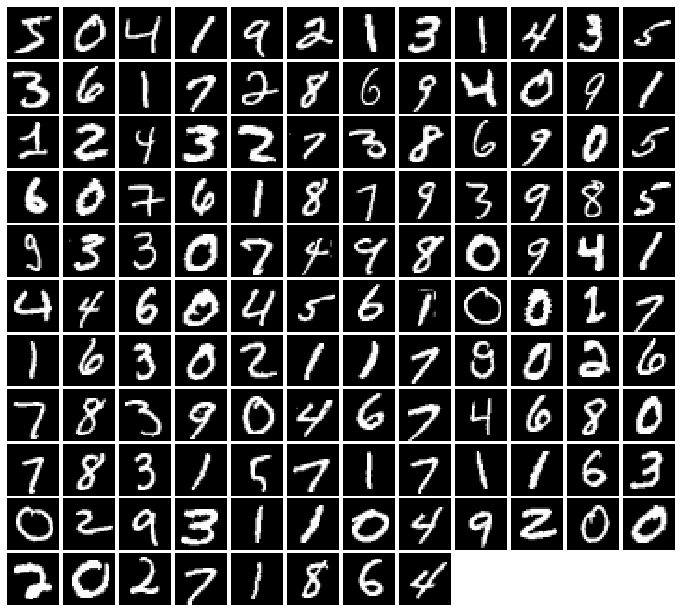

In [ ]:
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True, num_workers=5)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

### Section 1.1.4 Train your model [7 pts]

- Call Discriminator and Generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with lr=1e-3, betas = (0.5, 0.999))
- Call train function to train. 
- Train for 10 epochs.

After training your GAN model, you should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_gan.jpg" width=300>
Refer mnist.jpg from gan_samples folder.

EPOCH:  1
Iter: 0, D: 1.037, G:0.7278


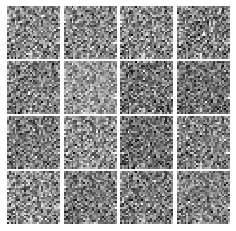


Iter: 250, D: 0.5582, G:1.085


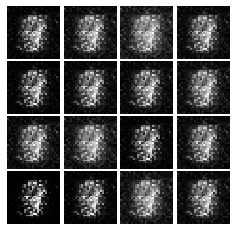


Saving the model as a checkpoint...
EPOCH:  2
Iter: 500, D: 0.8195, G:1.087


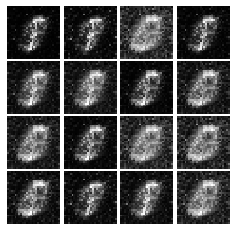


Iter: 750, D: 0.6385, G:1.083


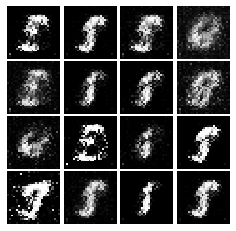


Saving the model as a checkpoint...
EPOCH:  3
Iter: 1000, D: 0.7514, G:0.8606


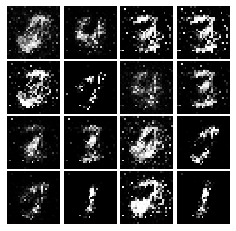


Iter: 1250, D: 0.6141, G:0.9649


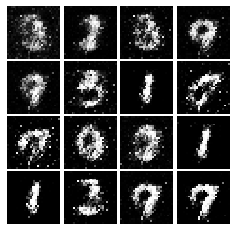


Saving the model as a checkpoint...
EPOCH:  4
Iter: 1500, D: 0.7375, G:1.031


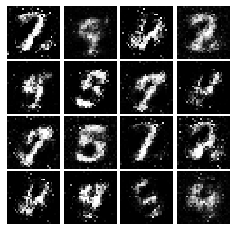


Iter: 1750, D: 0.749, G:0.626


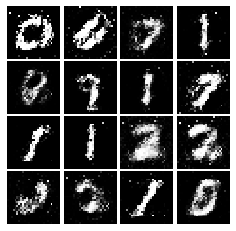


Saving the model as a checkpoint...
EPOCH:  5
Iter: 2000, D: 0.7939, G:0.6308


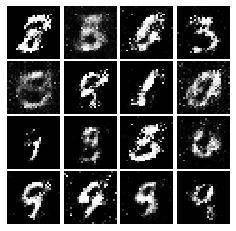


Iter: 2250, D: 0.877, G:0.6185


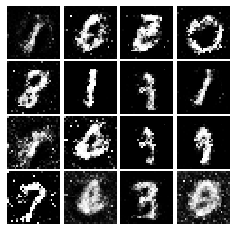


Saving the model as a checkpoint...
EPOCH:  6
Iter: 2500, D: 0.8503, G:0.6729


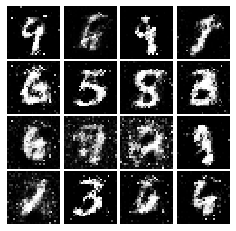


Iter: 2750, D: 0.9034, G:0.652


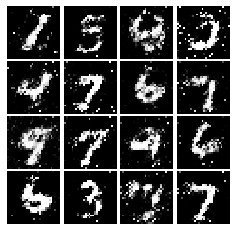


Saving the model as a checkpoint...
EPOCH:  7
Iter: 3000, D: 0.8297, G:0.5976


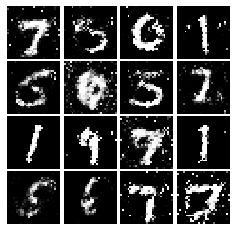


Iter: 3250, D: 0.8817, G:0.6655


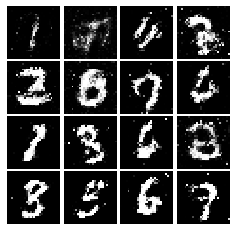


Saving the model as a checkpoint...
EPOCH:  8
Iter: 3500, D: 0.8733, G:0.6287


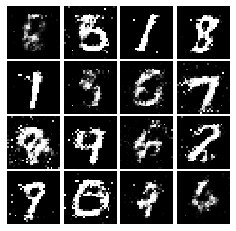


Saving the model as a checkpoint...
EPOCH:  9
Iter: 3750, D: 0.8744, G:0.5822


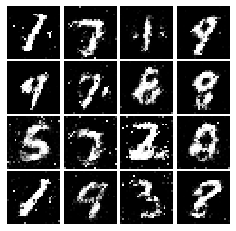


Iter: 4000, D: 0.8669, G:0.6131


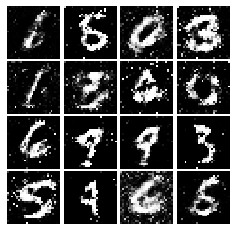


Saving the model as a checkpoint...
EPOCH:  10
Iter: 4250, D: 0.9142, G:0.5823


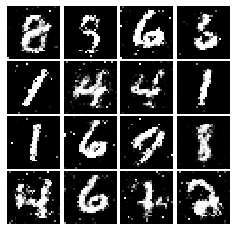


Iter: 4500, D: 0.8702, G:0.59


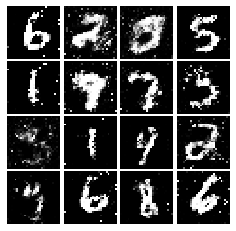


Saving the model as a checkpoint...


In [ ]:
# original GAN
# Add code here:
# Call discriminator and generator for training.
# Call optimizers for both discriminator and generator for training. (Use Adam with lr=1e-3, betas = (0.5, 0.999))
# Call train function to train. Run for 10 epochs.

D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))


train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

## Section 1.2 Least-square GAN Loss
### Section 1.2.1 LSGAN Loss [10 pts]
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Fill in the `ls_discriminator_loss` and `ls_generator_loss` in the cell below.

**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [ ]:
def ls_discriminator_loss(logits_real, logits_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
 
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    #logits_real = logits_real.to(device)
    #logits_fake = logits_fake.to(device)
    loss = 0.5 * (logits_real - 1).pow(2) + 0.5 * logits_fake.pow(2)
    loss = loss.mean() 
    ##########       END      ##########
    return loss

def ls_generator_loss(logits_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
 
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """

    loss = None
 
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    #logits_fake = logits_fake.to(device)
    loss = 0.5 * (logits_fake - 1).pow(2)
    loss = loss.mean()

    ##########       END      ##########
    return loss    

### Section 1.2.2 Train model with LSGAN loss[7 pts]

- Call Discriminator and Generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with lr=1e-3, betas = (0.5, 0.999))
- Call train function to train. 
- Train for 10 epochs.

Similarly, train your LSGAN on MNIST dataset. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_ls.jpg" width=300>

EPOCH:  1
Iter: 0, D: 0.4028, G:0.4521


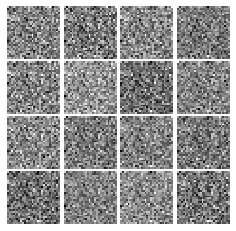


Iter: 250, D: 0.1184, G:0.2328


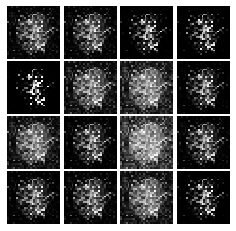


Saving the model as a checkpoint...
EPOCH:  2
Iter: 500, D: 0.158, G:0.3923


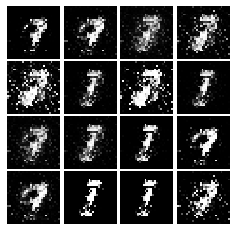


Iter: 750, D: 0.1339, G:0.2913


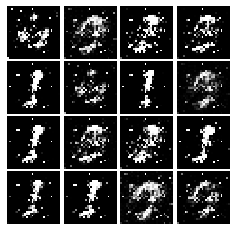


Saving the model as a checkpoint...
EPOCH:  3
Iter: 1000, D: 0.1393, G:0.4838


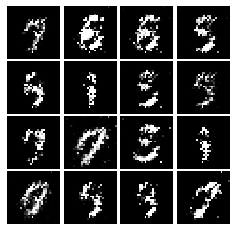


Iter: 1250, D: 0.156, G:0.3323


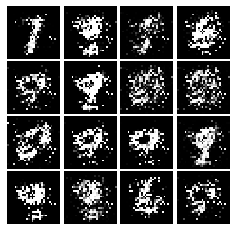


Saving the model as a checkpoint...
EPOCH:  4
Iter: 1500, D: 0.2581, G:0.2567


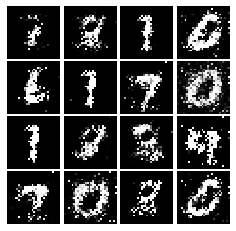


Iter: 1750, D: 0.1718, G:0.2795


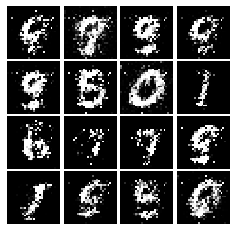


Saving the model as a checkpoint...
EPOCH:  5
Iter: 2000, D: 0.2243, G:0.1687


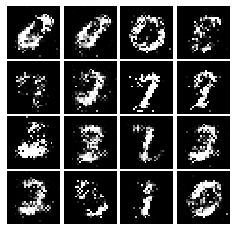


Iter: 2250, D: 0.2067, G:0.2223


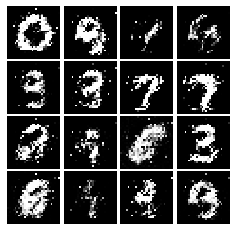


Saving the model as a checkpoint...
EPOCH:  6
Iter: 2500, D: 0.1736, G:0.1694


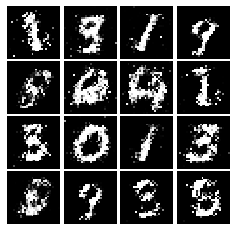


Iter: 2750, D: 0.2447, G:0.1644


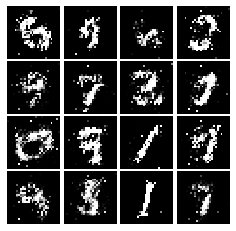


Saving the model as a checkpoint...
EPOCH:  7
Iter: 3000, D: 0.245, G:0.1451


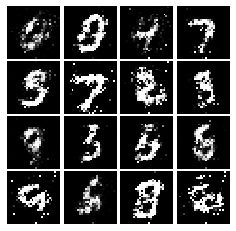


Iter: 3250, D: 0.2225, G:0.1524


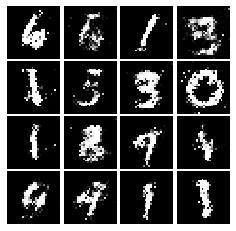


Saving the model as a checkpoint...
EPOCH:  8
Iter: 3500, D: 0.2397, G:0.1465


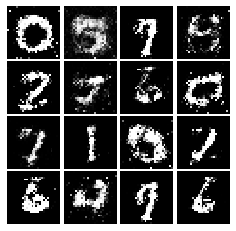


Saving the model as a checkpoint...
EPOCH:  9
Iter: 3750, D: 0.2197, G:0.1601


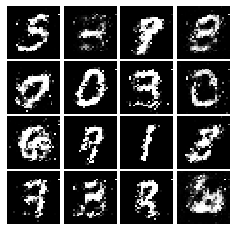


Iter: 4000, D: 0.239, G:0.1642


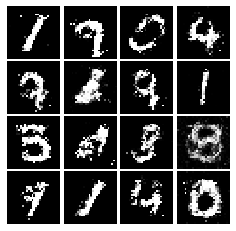


Saving the model as a checkpoint...
EPOCH:  10
Iter: 4250, D: 0.2226, G:0.1905


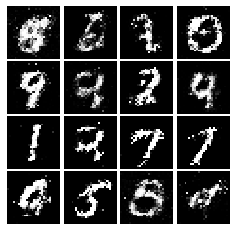


Iter: 4500, D: 0.2154, G:0.1591


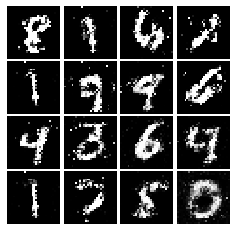


Saving the model as a checkpoint...


In [ ]:
# YOUR TRAINING CODE HERE
D_LS = discriminator().type(dtype).to(device)
G_LS = generator().type(dtype).to(device)
D_LS_solver = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_solver = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))


train(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)

# Section 2. Generative Adversarial Networks on CelebA Dataset [56 pts]

In this section, you will need to:
1. Implement DCGAN architecture
2. Train it on CelebA dataset.

We are done with the simple, not-so-challenging MNIST dataset. Now, you need to implement a specific model architecture called [DCGAN](https://arxiv.org/pdf/1511.06434.pdf), and train your model to generate human faces!

### Section 2.1. GAN model architecture [20 pts]

Implement your generator and discriminator for generating faces. We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):
**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Instead of Relu we use LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). 

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [ ]:
# YOUR GENERATOR/DISCRIMINATOR HERE
NOISE_DIM = 100

def discriminator():
    """
    Initialize and return a simple discriminator model.
    """

    model = torch.nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
      
        )


    # Your code here:
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
  
    """
    # Your code here:
    # [128, 100] -> [128, 100, 1, 1]
    # # 
    # model = torch.nn.Sequential(
    #         nn.ConvTranspose2d( noise_dim, 1024, 4, 1, 0, bias=False),
    #         nn.BatchNorm2d(1024),
    #         nn.ReLU(True),
    #         # state size. (ngf*8) x 4 x 4
    #         nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
    #         nn.BatchNorm2d(512),
    #         nn.ReLU(True),
    #         # state size. (ngf*4) x 8 x 8
    #         nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
    #         nn.BatchNorm2d(256),
    #         nn.ReLU(True),
    #         # state size. (ngf*2) x 16 x 16
    #         nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
    #         nn.BatchNorm2d(128),
    #         nn.ReLU(True),
    #         # state size. (ngf) x 32 x 32
    #         nn.ConvTranspose2d( 128, 3, 4, 2, 1, bias=False),
    #         nn.Tanh()
    #         # state size. (nc) x 64 x 64
    #     )

    # return model

class Generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            nn.ConvTranspose2d( noise_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    
    def forward(self, x):
        # [Batch size, 100] -> [Batch size, 100, 1, 1]
        x = x.view(-1, 100, 1, 1)
        
        out = self.model(x)
        
        return out

### Section 2.2 Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

Run download_celeba.sh to get dataset.

In [ ]:
!wget https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
!mkdir celeba_data
!unzip q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip -d celeba_data
!rm q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
#!cp -r /content/celeba_data /content/drive/My Drive/DL_Fall_2020/Assignment_5/

Streaming output truncated to the last 5000 lines.
  inflating: celeba_data/celeba_train_128res/175430_crop.jpg  
  inflating: celeba_data/celeba_train_128res/157564_crop.jpg  
  inflating: celeba_data/celeba_train_128res/039881_crop.jpg  
  inflating: celeba_data/celeba_train_128res/150303_crop.jpg  
  inflating: celeba_data/celeba_train_128res/145071_crop.jpg  
  inflating: celeba_data/celeba_train_128res/165362_crop.jpg  
  inflating: celeba_data/celeba_train_128res/197644_crop.jpg  
  inflating: celeba_data/celeba_train_128res/015423_crop.jpg  
  inflating: celeba_data/celeba_train_128res/188193_crop.jpg  
  inflating: celeba_data/celeba_train_128res/124213_crop.jpg  
  inflating: celeba_data/celeba_train_128res/160818_crop.jpg  
  inflating: celeba_data/celeba_train_128res/169663_crop.jpg  
  inflating: celeba_data/celeba_train_128res/066406_crop.jpg  
  inflating: celeba_data/celeba_train_128res/135163_crop.jpg  
  inflating: celeba_data/celeba_train_128res/116258_crop.jpg  
  in

In [ ]:
!cp -r /content/celeba_data /content/drive/My\ Drive/Assignment_5/

^C


In [ ]:
#Give path to that folder and run,
import sys
sys.path, dirs, files = next(os.walk("/content/drive/My Drive/Assignment_5/celeba_data/celeba_train_128res"))
file_count = len(files)
print(file_count)

33518


In [ ]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = 'celeba_data'

In [ ]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

# You can change the num_workers to speed up loading
celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True, num_workers=12)

#### Visualize dataset

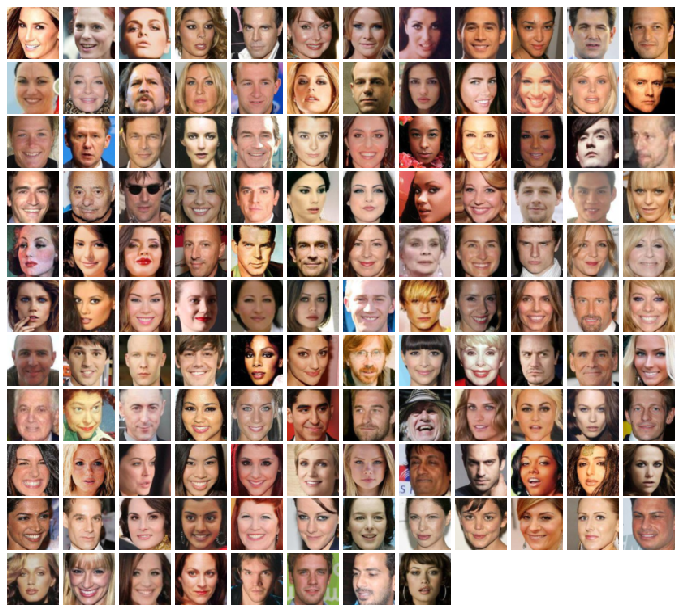

In [ ]:
imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

### Section 2.3 Train a Vanilla GAN on CelebA [13 pts]

- Call discriminator and generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with betas = (0.5, 0.999))
- Call train function to train. 
- Train for 30 epochs.

Now, train your GAN model with vanilla GAN loss. If you models are implemented correctly, you should see something like this:
<img src="files/gan_samples/celeba.jpg" width=300>


Now, train your model. **Observe the visualized result of your model, and describe what you see.** as the number of epoch inncreases, we see some faces are being shaped which means the generator is learning how to generate faces. Different faces are created at different iteration and as the number of epoch is increased the images are becoming more realistic

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 30
learning_rate = 0.0002

In [ ]:
# original GAN
# Add code here:
# YOUR TRAINING CODE HERE
D = discriminator().type(dtype).to(device)
# G = generator().type(dtype).to(device)
G = Generator().to(device)


D_solver = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, 
      train_loader=celeba_loader_train, device=device)

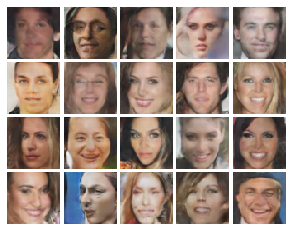

In [ ]:
weight_G = torch.load("/content/drive/MyDrive/Assignment_5/ckpts/Vanilla_gan_MINST/checkpoint.pth")["G"]
G = Generator().to(device)
G.load_state_dict(weight_G)
batch_size = 20
z= sample_noise(batch_size,100).to(device)
z.view(-1,100,1,1)
image = G(z)
disp_fake_images = deprocess_img(image.data)  # denormalize
imgs_numpy = (disp_fake_images).cpu().numpy()
show_images(imgs_numpy[0:20], color=True)
plt.show()
ckpt_dir = "/content/drive/MyDrive/Assignment_5/ckpts/generated_images"
os.makedirs(ckpt_dir, exist_ok=True)



#plt.imshow(np.swapaxes(np.swapaxes(imgs_numpy, 0, 1), 1, 2)
for i in range(batch_size):
  plt.imsave(os.path.join(ckpt_dir, "image{}.jpg").format(i, '02d'), imgs_numpy[i].transpose(1, 2, 0))

             






### Section 2.4 Train a LSGAN on CelebA [13 pts]

- Call discriminator and generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with betas = (0.5, 0.999))
- Call train function to train. 
- Train for 30 epochs.

Now, train your GAN model with LSGAN loss. **Observe the visualized result of your model, and describe what you see.**tHE same as Vanilla GAN network, as the number of iterations in each epoch increases more realistic image are made which means the genrator is learning.
from different references the LSGAN loss function is more stable alternative to the original GAN loss function.

In [ ]:
# LSGAN
# YOUR TRAINING CODE HERE
D_LS = discriminator().type(dtype).to(device)
G_LS = Generator().to(device)


D_LS_solver = torch.optim.Adam(D_LS.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_LS_solver = torch.optim.Adam(G_LS.parameters(), lr=learning_rate, betas = (0.5, 0.999))



train(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, train_loader=celeba_loader_train, device=device, ckpt_dir =path_to_homework+ '/ckpts/Vanilla_lsgan_MINST/')
# Add code here:

### Section 2.6 Conclusion? [10 pts]
You have successfully trained you GAN models. Hurray! Now, we want you to answer the following question in few sentences.
1. Have you observed any difference between GAN and LSGAN (e.g. training, generation quality)? the quality of images in LSGAN is a little better  than GAN

2. Did your GAN models generate you diverse faces? Or did it should give you similar stuff all the time? I see diverse images in diffrent epochs and iterations
3. How can you quantitatively evaluate your GAN model? Is the metric(s) meaningful? Is there any drawback about this metric(s)? There are Quantitative measures, such as the inception score, the Frechet inception distance (FID), However, they can be combined with qualitative assessment to provide a robust assessment of GAN models. Drawback of the Inception Score is that the statistics of real world samples are not used and compared to the statistics of synthetic samples.(https://machinelearningmastery.com/)


### Guidelines for Downloading PDF in Google Colab
- Run below cells only in Google Colab, Comment out in case of Jupyter notebook

In [ ]:
#Run below two lines (in google colab), installation steps to get .pdf of the notebook

#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

# After installation, comment above two lines and run again to remove installation comments from the notebook.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
# Find path to your notebook file in drive and enter in below line

!jupyter nbconvert --to PDF "/content/drive/MyDrive/Assignment_5/Assignment_5_1.ipynb"

#Example: "/content/drive/My Drive/DL_Fall_2020/Assignment_5/DL_Assignment_5.ipynb"

[NbConvertApp] WARNING | pattern u'/content/drive/MyDrive/Assignment_5/Assignment_5_1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default ba